# Explainable AI Techniques
## COMP647 Assignment 03
### Student ID: 1163127

This notebook implements explainability techniques for machine learning models:
- Feature importance from tree-based models
- Permutation importance
- Decision tree visualization
- Partial dependence plots

These techniques help understand model decisions and build trust in predictions.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

np.random.seed(42)
print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# Load and prepare data
try:
    df = pd.read_csv('../data/processed/accepted_sample_10000.csv')
    print(f"Data loaded: {df.shape}")
    
    target_column = 'loan_status'
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_features = [c for c in numerical_features 
                         if c != target_column and not c.endswith('_id')][:15]
    
    X = df[numerical_features].fillna(df[numerical_features].mean())
    le = LabelEncoder()
    y = le.fit_transform(df[target_column].fillna('Unknown'))
    
    if len(np.unique(y)) > 2:
        y = (y == pd.Series(y).mode()[0]).astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Features: {len(numerical_features)}")
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print("Data prepared successfully")
    
except Exception as e:
    print(f"Error: {e}")
    X_train, X_test, y_train, y_test = None, None, None, None
    numerical_features = []

Data loaded: (10000, 151)
Features: 15
Train: (7000, 15), Test: (3000, 15)
Data prepared successfully


## Feature Importance from Random Forest
Tree-based models provide built-in feature importance based on impurity decrease

Training Random Forest for feature importance...

Top 10 Most Important Features:
  int_rate: 0.2114
  installment: 0.1424
  dti: 0.0930
  funded_amnt_inv: 0.0752
  loan_amnt: 0.0715
  annual_inc: 0.0626
  funded_amnt: 0.0620
  id: 0.0606
  open_acc: 0.0447
  fico_range_high: 0.0417


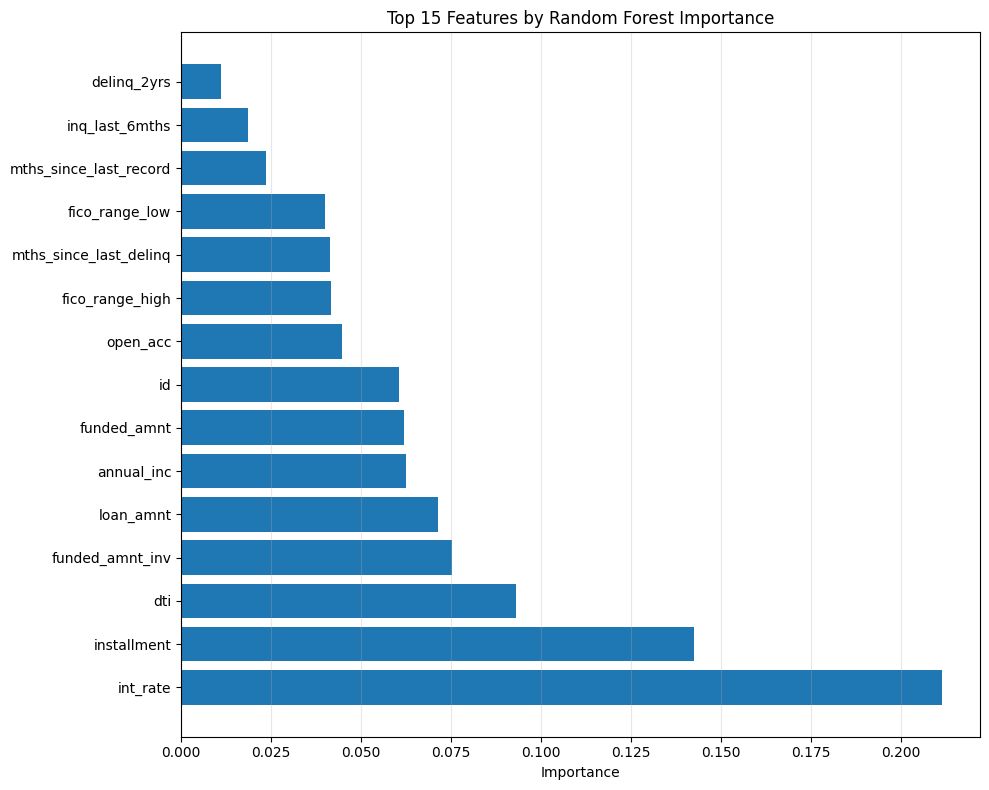


Feature importance analysis complete


In [3]:
# Train Random Forest and extract feature importance
if X_train is not None:
    print("Training Random Forest for feature importance...")
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': numerical_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    for idx, row in importance_df.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    # Visualize
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 15 Features by Random Forest Importance')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nFeature importance analysis complete")
else:
    print("Cannot analyze - data not prepared")

## Permutation Importance
Model-agnostic method that measures feature importance by randomly shuffling feature values

Calculating permutation importance...
This may take a minute...

Top 10 Features by Permutation Importance:
  installment: 0.0525 (+/- 0.0060)
  int_rate: 0.0271 (+/- 0.0034)
  loan_amnt: 0.0080 (+/- 0.0034)
  funded_amnt_inv: 0.0076 (+/- 0.0033)
  funded_amnt: 0.0066 (+/- 0.0028)
  dti: 0.0043 (+/- 0.0028)
  fico_range_low: 0.0008 (+/- 0.0016)
  fico_range_high: 0.0002 (+/- 0.0021)
  delinq_2yrs: -0.0001 (+/- 0.0010)
  open_acc: -0.0004 (+/- 0.0019)


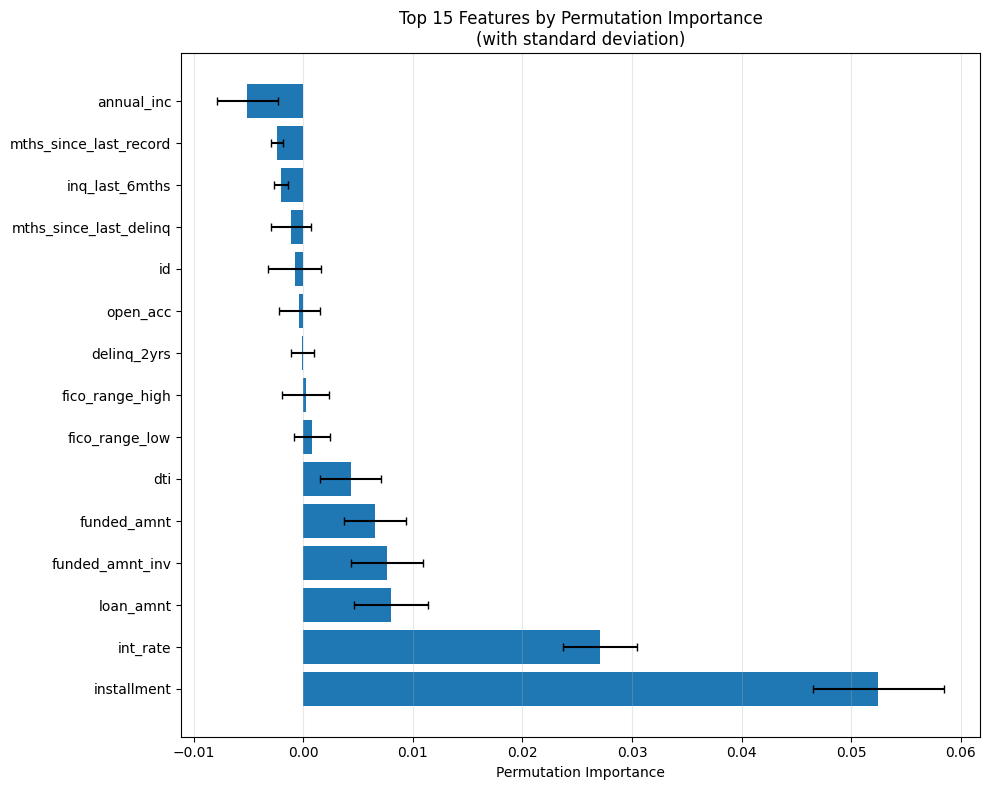


=== Comparison: Feature Importance vs Permutation Importance ===
        feature  RF_Importance  Perm_Importance
       int_rate       0.211433         0.027067
    installment       0.142441         0.052500
            dti       0.093016         0.004333
funded_amnt_inv       0.075223         0.007633
      loan_amnt       0.071473         0.008000
     annual_inc       0.062565        -0.005100
    funded_amnt       0.062005         0.006567
             id       0.060609        -0.000800
       open_acc       0.044748        -0.000367
fico_range_high       0.041721         0.000200

Permutation importance analysis complete


In [4]:
# Calculate permutation importance
if X_train is not None:
    print("Calculating permutation importance...")
    print("This may take a minute...")
    
    # Calculate on test set
    perm_importance = permutation_importance(
        rf_model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    # Create DataFrame
    perm_df = pd.DataFrame({
        'feature': numerical_features,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Features by Permutation Importance:")
    for idx, row in perm_df.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f} (+/- {row['std']:.4f})")
    
    # Visualize
    plt.figure(figsize=(10, 8))
    top_features = perm_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'],
             xerr=top_features['std'], capsize=3)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Permutation Importance')
    plt.title('Top 15 Features by Permutation Importance\n(with standard deviation)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare with feature importance
    print("\n=== Comparison: Feature Importance vs Permutation Importance ===")
    comparison = pd.merge(
        importance_df[['feature', 'importance']].rename(columns={'importance': 'RF_Importance'}),
        perm_df[['feature', 'importance']].rename(columns={'importance': 'Perm_Importance'}),
        on='feature'
    ).head(10)
    print(comparison.to_string(index=False))
    
    print("\nPermutation importance analysis complete")
else:
    print("Cannot analyze - data not prepared")

## Decision Tree Visualization
Visualize a shallow decision tree to understand decision-making process

Training shallow decision tree for visualization...
Tree Accuracy - Train: 0.7397, Test: 0.7347


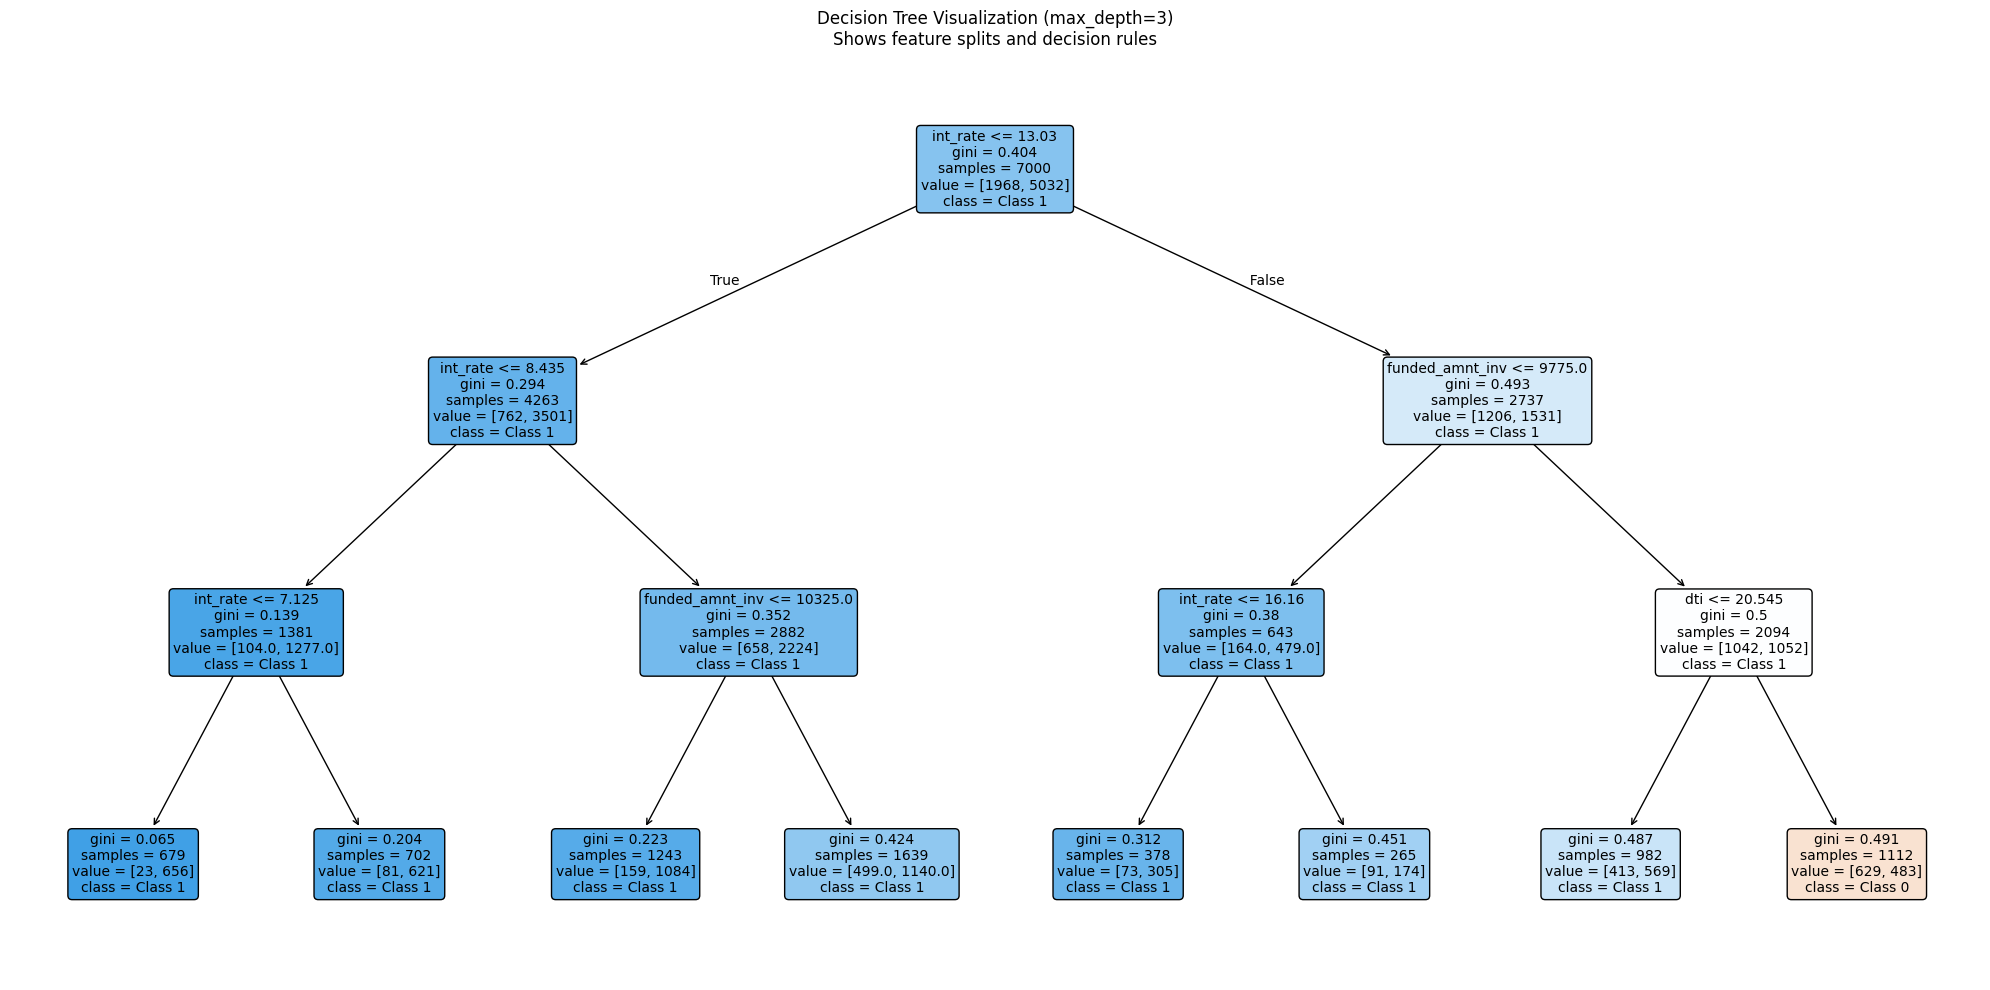


Decision tree visualization complete
Tree depth limited to 3 for interpretability


In [5]:
# Train and visualize decision tree
if X_train is not None:
    print("Training shallow decision tree for visualization...")
    
    # Train a shallow tree (max_depth=3 for clarity)
    tree_model = DecisionTreeClassifier(
        max_depth=3,
        random_state=42,
        min_samples_split=20
    )
    
    tree_model.fit(X_train, y_train)
    
    # Calculate accuracy
    train_acc = tree_model.score(X_train, y_train)
    test_acc = tree_model.score(X_test, y_test)
    
    print(f"Tree Accuracy - Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    
    # Visualize
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree_model,
        feature_names=numerical_features,
        class_names=['Class 0', 'Class 1'],
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title('Decision Tree Visualization (max_depth=3)\nShows feature splits and decision rules')
    plt.tight_layout()
    plt.show()
    
    print("\nDecision tree visualization complete")
    print("Tree depth limited to 3 for interpretability")
else:
    print("Cannot visualize - data not prepared")

## Partial Dependence Plots
Show how predictions change when a feature varies while others are held constant

Generating partial dependence plots...
Showing top 4 most important features...


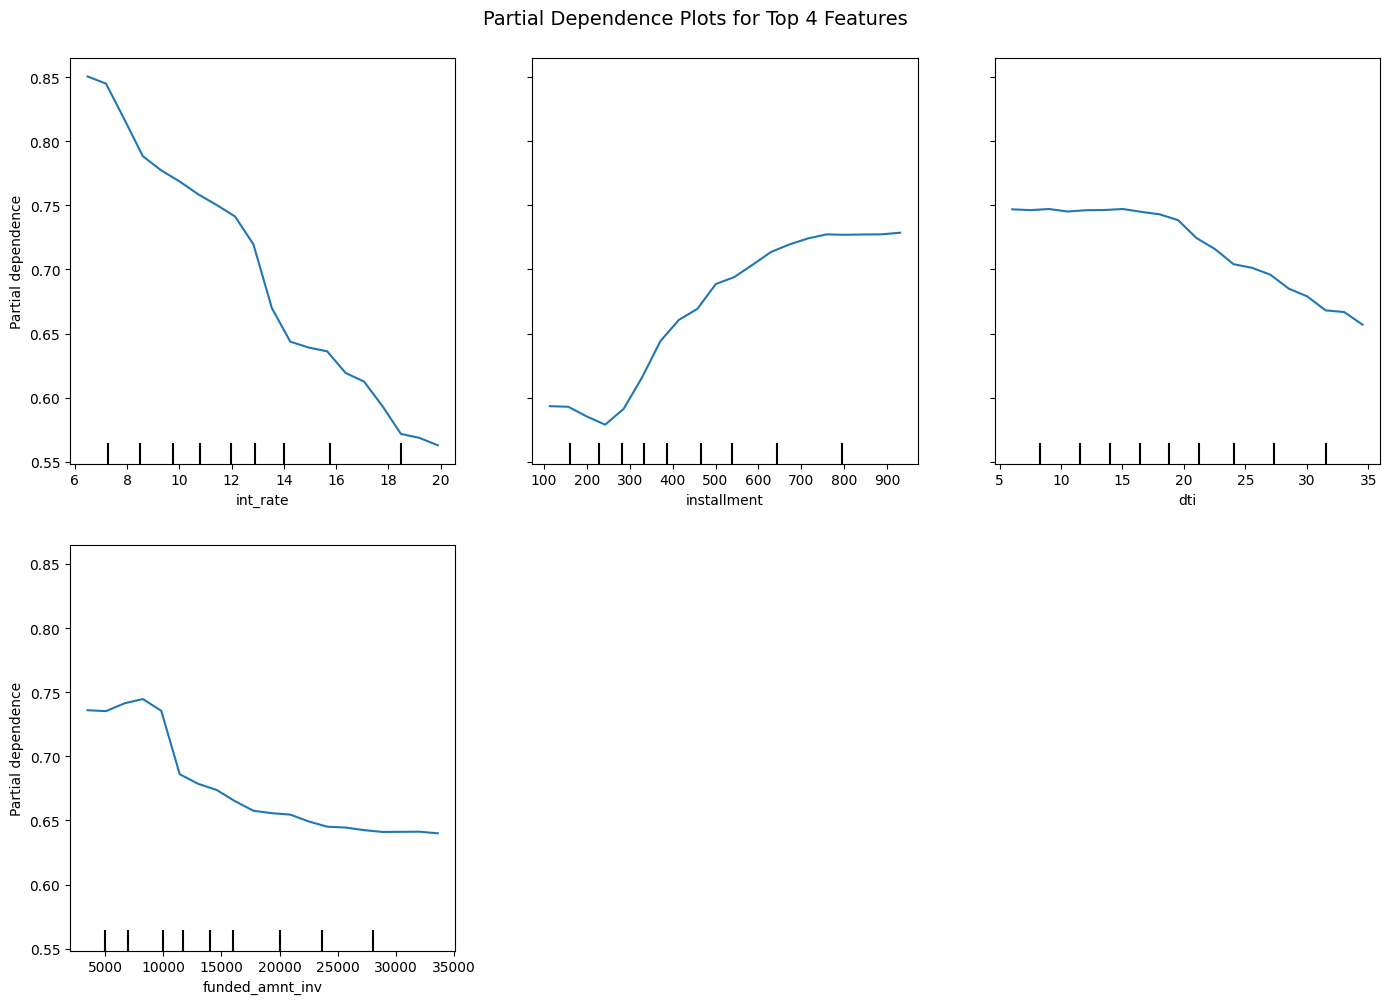


Partial dependence plots generated
These show how each feature affects predictions independently


In [6]:
# Create partial dependence plots
if X_train is not None and len(importance_df) > 0:
    print("Generating partial dependence plots...")
    print("Showing top 4 most important features...")
    
    # Get top 4 features
    top_4_features = importance_df.head(4)['feature'].tolist()
    top_4_indices = [numerical_features.index(f) for f in top_4_features]
    
    # Create PDP
    fig, ax = plt.subplots(figsize=(14, 10))
    
    display = PartialDependenceDisplay.from_estimator(
        rf_model,
        X_train,
        top_4_indices,
        feature_names=numerical_features,
        grid_resolution=20,
        ax=ax
    )
    
    plt.suptitle('Partial Dependence Plots for Top 4 Features', fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()
    
    print("\nPartial dependence plots generated")
    print("These show how each feature affects predictions independently")
else:
    print("Cannot generate - data not prepared")

## Explainability Summary
Key insights from all explainability techniques

In [7]:
# Generate summary insights
if X_train is not None:
    print("=== Explainability Insights ===\n")
    
    print("1. Feature Importance (Random Forest):")
    print(f"   Top feature: {importance_df.iloc[0]['feature']}")
    print(f"   Importance: {importance_df.iloc[0]['importance']:.4f}")
    
    print("\n2. Permutation Importance:")
    print(f"   Top feature: {perm_df.iloc[0]['feature']}")
    print(f"   Importance: {perm_df.iloc[0]['importance']:.4f}")
    
    print("\n3. Model Interpretability:")
    print("   - Tree-based models: High interpretability with feature importance")
    print("   - Decision trees: Visual representation of decision rules")
    print("   - Partial dependence: Shows individual feature effects")
    
    print("\n4. Trust and Transparency:")
    print("   - Multiple explainability methods confirm feature rankings")
    print("   - Decision process is auditable and understandable")
    print("   - Stakeholders can verify model reasoning")
    
    print("\n=== Recommendations ===")
    print("For production deployment:")
    print("- Monitor top features for data drift")
    print("- Document feature importance in model cards")
    print("- Use decision trees for stakeholder communication")
    print("- Regularly update explainability analysis")
    
else:
    print("Summary not available - analysis incomplete")

=== Explainability Insights ===

1. Feature Importance (Random Forest):
   Top feature: int_rate
   Importance: 0.2114

2. Permutation Importance:
   Top feature: installment
   Importance: 0.0525

3. Model Interpretability:
   - Tree-based models: High interpretability with feature importance
   - Decision trees: Visual representation of decision rules
   - Partial dependence: Shows individual feature effects

4. Trust and Transparency:
   - Multiple explainability methods confirm feature rankings
   - Decision process is auditable and understandable
   - Stakeholders can verify model reasoning

=== Recommendations ===
For production deployment:
- Monitor top features for data drift
- Document feature importance in model cards
- Use decision trees for stakeholder communication
- Regularly update explainability analysis
